In [511]:
%reset -f

In [512]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import math

In [513]:
df_Me = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_methanol.xlsx')
df_Iso = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_isopropanol.xlsx')

In [514]:
# Heat Capacity Methanol
# Getting data from file and making fitted line
Temp_list_Me = df_Me['Temperature'].values.tolist()
Cp_list_Me = df_Me['Cp'].values.tolist()
a_Me, b_Me, c_Me = np.polyfit(Temp_list_Me, Cp_list_Me, deg=2)

'''plt.plot(Temp_list_Me, Cp_list_Me, "o")
plt.plot(Temp_list_Me, np.polyval((a_Me, b_Me, c_Me),Temp_list_Me), "-")
plt.xlabel('T[K]')
plt.ylabel('Cp') 
plt.title('Methanol heat capacity')
plt.show()'''

# Heat Capacity Isopropanol
# Getting data and making fitted line
Temp_list_Iso = df_Iso['Temp'].values.tolist()
Cp_list_Iso = df_Iso['Cp'].values.tolist()
a_Iso, b_Iso, c_Iso = np.polyfit(Temp_list_Iso, Cp_list_Iso, deg=2)
Temps_Iso_model = np.linspace(-20, 85, 22)
Temps_Iso_model_K  = [x+273.15 for x in Temps_Iso_model] # convert to Kelvin

'''plt.plot(Temp_list_Iso, Cp_list_Iso, "o")
plt.plot(Temps_Iso_model_K, np.polyval((a_Iso, b_Iso, c_Iso), Temps_Iso_model_K), "-")
plt.xlabel('T[K]') # label on the x axis
plt.ylabel('Cp') # label on the y axis
plt.title('Isopropanol heat capacity')
plt.show()'''

'plt.plot(Temp_list_Iso, Cp_list_Iso, "o")\nplt.plot(Temps_Iso_model_K, np.polyval((a_Iso, b_Iso, c_Iso), Temps_Iso_model_K), "-")\nplt.xlabel(\'T[K]\') # label on the x axis\nplt.ylabel(\'Cp\') # label on the y axis\nplt.title(\'Isopropanol heat capacity\')\nplt.show()'

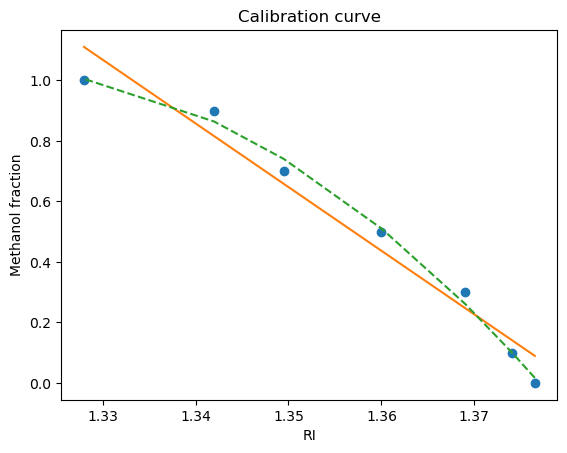

0.5105995532411498


In [515]:
# Refractive Index Calibration Curve

#Measurements
Me_fraction = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
RI = [1.3765, 1.374, 1.369, 1.360, 1.3495, 1.342, 1.328]

#fitting line at multiple degrees
Cal_a_fit, Cal_b_fit = np.polyfit(RI, Me_fraction, deg=1)
Cal_a_fit2, Cal_b_fit2, Cal_c_fit2 = np.polyfit(RI, Me_fraction, deg=2)

plt.plot(RI, Me_fraction,"o")
plt.plot(RI, np.polyval((Cal_a_fit, Cal_b_fit), RI),"-")
plt.plot(RI, np.polyval((Cal_a_fit2, Cal_b_fit2, Cal_c_fit2), RI), "--")
plt.xlabel("RI")
plt.ylabel("Methanol fraction")
plt.title('Calibration curve')
plt.show()

def Calibration(RI):
    Me_ratio = RI**2 * Cal_a_fit2 + RI*Cal_b_fit2 + Cal_c_fit2
    return Me_ratio

#use calibration function to get the methanol fraction
Me_frac = Calibration(1.36)
print(Me_frac)

In [516]:
# Constants for entire system 
p_atm = 101.325  # Atmospheric pressure in Pa
R = 8.3144598    # Gas constant J/molK
g = 9.807        # Gravitational acceleration m/s^2

# Mass transfer coefficients 
k_me =  (10**3.4) * ((1.0020+1.2598)/2)*10**(-7) #m/s 
k_iso = (10**3.4)* ((2.47+3.17)/2)*10**(-10)     #m/s

In [517]:
# Reboiler info and trey
A_r = 5                  # Evaporation surface area m2
dH_vap_Me = 37600        # Enthalpy of vaporisation methanol at boiling point [J/mol]
dH_vap_iso = 45*10**3
eff = 1 #640/751         # Heater efficiency (around 0.85)
T0 = 298                 #K
V  = 0.01                # Volume of mixture in reboiler [m^3]
Iso_frac = 1-Me_frac     # Mole fraction isopropanol
dens_Me = 792            #kg/m3
dens_Iso = 786           #kg/m3
M_Me = 32.02             #g/mol
M_Iso = 60.1             #g/mol
Vm_Me = 40.75            # molar volume methanol [cm^3/mol]
Vm = (M_Me/1000/dens_Me)*Me_frac + (M_Iso/1000/dens_Iso)*(1-Me_frac) # Molar volume of mixture [m^3/mol]
n_total = V/Vm           # Total number of moles in mixture
n_Me = Me_frac*n_total   # Number of moles of methanol
n_Iso = Iso_frac*n_total # Number of moles of isopropanol
dens_mix = (n_Me*M_Me + n_Iso*M_Iso)/V # Density of mixture [kg/m^3]
M_mix = (n_Me*M_Me + n_Iso*M_Iso)/1000 #kg/mol
power_percent = 0.7
power = eff*power_percent*2000 #J/s (maximum power is 2kW)
L_inflow = 2 * 0.001/3600 * dens_mix/M_mix #mol/s
A_t = ((2.5*0.01)**2) * math.pi  #surface area of one tray
A_a = ((0.05*0.01)**2) * math.pi #area of 1 hole in the top of a tray->throough which vapor goes out 
h_c = 2e-3                       #height weir
l_weir = 1e-1                    #length weir
w_weir = 1e-5                    #width weir
dp = 547.7                       #pressure drop over entire column
x_iso_in = 0.5                   #Isopropanol fraction inlet
x_me_in = 0.5                    #Methanol fraction inlet
RR = 0.2                         #Reflux ratio

In [518]:
# Heat capacity
def Cp_Iso(T):
    Cp_Iso = a_Iso * T**2 + b_Iso*T + c_Iso
    return Cp_Iso

def Cp_Me(T):
    Cp_Me = a_Me * T**2 + b_Me * T + c_Me
    return Cp_Me

def Cp_mix(Me_frac,T):
    Cp_mix = Me_frac*Cp_Me(T) + (1-Me_frac)*Cp_Iso(T)
    return Cp_mix

def dens_mix(x_me):
    dens_Me = 792            #kg/m3
    dens_Iso = 786           #kg/m3
    dens_mix = (x_me*dens_Me + (1-x_me)*dens_Iso)
    return dens_mix

# Vapor pressure for both compounds in the reboiler
def p0_me(T):
    #Antonie constants-methanol 
    A_me = 5.20409
    B_me = 1581.341
    C_me = -33.50
    #vapour pressure 
    p0_me = (10**(A_me - B_me/(T+C_me)))*(10**5)     #Pa
    return p0_me   


def p0_iso(T):
    #Antoine constants isopropanol
    A_iso = 4.8610
    B_iso =	1357.427
    C_iso = -75.814
    #vapour pressure 
    p0_iso = (10**(A_iso - B_iso/(T+C_iso)))*(10**5)    #Pa
    return p0_iso


In [519]:
# Condenser info 
T_cool = 300  # Temperature in K
A_c = 5          # Evaporation surface area m2

#Antonie constants methanol 
A_me = 5.20409
B_me = 1581.341
C_me = -33.50
    
#Antoine constants isopropanol
A_iso = 4.8610
B_iso =	1357.427
C_iso = -75.814

# Partial pressure with constant T_cool
p0_me_condenser = (10**(A_me - B_me/(T_cool+C_me)))*10**5  
p0_iso_condenser = (10**(A_iso - B_iso/(T_cool+C_iso)))*10**5 

In [520]:
params = {
    'Me_frac': Me_frac,   
    'n_total': n_total,
    'power': power,
    'A_r': A_r, 
    'R': R,        # Gas constant
    'k_me': k_me,  # mass coefficient methanol,
    'k_iso': k_iso, # mass coefficient isopropanol
    'p_atm': p_atm,
    'dH_vap_Me': dH_vap_Me,
    'A_c': A_c,
    'T_cool': T_cool,
    'p0_me_condenser': p0_me_condenser,
    'p0_iso_condenser': p0_iso_condenser,
    'L_inflow': L_inflow,
    'dens_mix': dens_mix,
    'A_a': A_a,
    'g': g,
    'h_c': h_c,
    'l_weir': l_weir,
    'dp': dp,
    'RR': RR,
    'x_iso_in': x_iso_in,
    'x_me_in': x_me_in,
    'A_tray': A_t,
    'w_weir': w_weir
}

In [521]:
def modelODE(N,t,params):
    T_cool = params['T_cool']
    A_r = params['A_r']
    A_c = params['A_c']
    k_me = params['k_me']
    k_iso = params['k_iso']
    p_atm = params['p_atm']
    Me_frac = params['Me_frac']
    power = params['power']
    p0_me_condenser = params['p0_me_condenser']
    p0_iso_condenser = params['p0_iso_condenser']
    L_inflow = params['L_inflow']
    dp = params['dp']
    dens_mix = params['dens_mix']
    A_a = params['A_a']
    RR = params['RR']
    x_iso_in =  params['x_iso_in']
    x_me_in = params['x_me_in']
    A_tray = params['A_tray']
    w_weir = params['w_weir']
    
    Q_cool = 104 #J/s enthalpy going out of condenser to cooling water
    T_ref = 298.15 
    T_tray = 337.8
    k_weir = 3.33 #weir coefficient

    Nme_LR = N[0]
    Niso_LR = N[1]
    Nme_vR = N[2]
    Niso_vR = N[3]
    Nme_L_tray = N[5]
    Niso_L_tray = N[6]
    Nme_v_tray = N[7]
    Niso_v_tray = N[8]
    T = N[4]
    
    #mol fractions 
    y_meR = Nme_vR/(Niso_vR+Nme_vR)
    x_meR = Nme_LR/(Nme_LR+Niso_LR)
    y_isoR = Niso_vR/(Niso_vR+Nme_vR)
    x_isoR = Niso_LR/(Nme_LR+Niso_LR)
    y_me_tray = Nme_v_tray/(Niso_v_tray+Nme_v_tray)
    x_me_tray = Nme_L_tray/(Nme_L_tray+Niso_L_tray)
    y_iso_tray = Niso_v_tray/(Niso_v_tray+Nme_v_tray)
    x_iso_tray = Niso_L_tray/(Nme_L_tray+Niso_L_tray)

    
    dNdt = np.zeros(9)
    
    evap_me = k_me*A_r * ((x_meR*p0_me(T) - p_atm*y_meR)/(R*T))
    evap_iso = k_iso*A_r * ((x_isoR*p0_iso(T) - p_atm*y_isoR)/(R*T))
    evap_tray_me = k_me*A_tray * ((x_me_tray*p0_me(T) - p_atm*y_me_tray)/(R*T))
    evap_tray_iso = k_iso*A_tray * ((x_iso_tray*p0_iso(T) - p_atm*y_iso_tray)/(R*T))
    N_L_tot = Nme_LR+Niso_LR

    L_weir = (0.415)*k_weir*(math.sqrt(l_weir**3))*w_weir*(math.sqrt(2*g))*dens_mix(x_me_tray)*(1/M_mix)  #Francis equation
    #V_tray = dp * (k_me*y_me_tray + k_iso*y_iso_tray)
    V_tray = (dens_mix(y_me_tray)/M_mix) * 10*A_a * k_me * math.sqrt((dp/8)/dens_mix(y_me_tray))
    L_condenser = (1/(Cp_mix(y_me_tray,T_cool)*(T_cool-T_ref))) * (V_tray*(Cp_mix(y_me_tray,T_tray)*(T_tray-T_ref)+dH_vap_Me+dH_vap_iso) - Q_cool)
    V_reboiler = (1/(Cp_mix(y_meR,T)*(T-T_ref)+dH_vap_Me+dH_vap_iso)) * (L_weir*Cp_mix(x_me_tray,T_tray)*(T_tray-T_ref) + V_tray*(Cp_mix(y_me_tray,T_tray)*(T_tray-T_ref)+dH_vap_iso+dH_vap_Me) - L_inflow*Cp_mix(x_me_in,T)*(T-T_ref) - L_condenser*Cp_mix(y_me_tray,T_cool)*(T_cool-T_ref))
    
    
    dNdt[0] = -evap_me + L_weir*x_me_tray      #meL Reboiler
    dNdt[1] = -evap_iso + L_weir*x_iso_tray    #isoL Reboiler
    dNdt[2] = evap_me - V_reboiler*y_meR       #meV Reboiler
    dNdt[3] = evap_iso - V_reboiler*y_isoR     #isoV Reboiler
    dNdt[4] = (1/(Cp_mix(x_meR,T)*N_L_tot))*(power + L_weir*Cp_mix(x_me_tray,T_tray)*(T_tray-T_ref) - V_reboiler*(Cp_mix(y_meR,T)*(T-T_ref)+dH_vap_Me+dH_vap_iso) - evap_me*dH_vap_Me - evap_iso*dH_vap_iso)  #energy balance reboiler 

    dNdt[5] = -evap_tray_me + L_inflow*x_me_in + L_condenser*(1-RR)*y_me_tray - L_weir*x_me_tray      #meL Tray
    dNdt[6] = -evap_tray_iso + L_inflow*x_iso_in + L_condenser*(1-RR)*y_iso_tray - L_weir*x_me_tray   #isoL Tray
    dNdt[7] = evap_tray_me + V_reboiler*y_meR - V_tray*y_me_tray       #meV Tray
    dNdt[8] = evap_tray_iso + V_reboiler*y_isoR - V_tray*y_iso_tray    #isoV Tray
    
    return dNdt

In [522]:
N_initial = [115, 115, 0.001, 0.001, 293, 0.01, 0.01, 0.001, 0.001] # meLR isoLR meVR isoVR T_reboiler  meLTray isoLtray meVtray isoVtray
tspan = np.linspace(0, 10000, 10000)
N = odeint(modelODE, N_initial, tspan, args = (params,))

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1041289285706D+04   r2 =  0.3210053588025D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1041289285706D+04   r2 =  0.3210053588025D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1041289285706D+04   r2 =  0.3210053588025D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1041289285706D+04   r2 =  0.4309206757094D-13
 lsoda--  warning..internal t (=r1) 

/Users/caterina/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [523]:
#print(N[:,5])

In [524]:
#print(N[:,6])

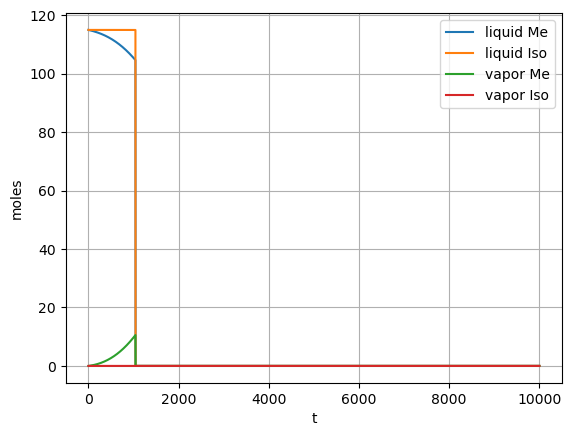

In [525]:
plt.plot(tspan, N[:,0], label = 'liquid Me')
plt.plot(tspan, N[:,1], label = 'liquid Iso')
plt.plot(tspan, N[:,2], label = 'vapor Me')
plt.plot(tspan, N[:,3], label = 'vapor Iso')
plt.legend()
plt.xlabel("t")
plt.ylabel("moles")
plt.grid()
plt.show()

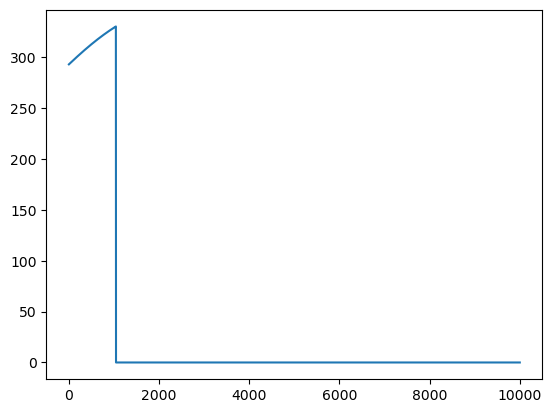

In [526]:
plt.plot(tspan,N[:,4])